# Evaluation of COSMO testruns with ERA5: bias maps

end-product: maps (COSMO, ERA5 and difference) for  variable and  metric 

Start:
- timmean for summer months

to extend: P90 of summer months

### 0. Settings

In [3]:
import valenspy as vp
from valenspy.preprocessing_tasks.regrid import remap_cdo

import xarray as xr
from pathlib import Path
import cdo 
from yaml import safe_load
import os
from eval_functions import *
import warnings

# Turn off all warnings
warnings.filterwarnings('ignore')

# define machine name - used for paths of (observational) datasets
machine = 'hortense'

# postprocessing base directory 
postproc_base_dir = "/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/"

src_path = Path("../src/valenspy")


In [4]:

# reference dataset to compare to
model = 'CCLM'

# get lookup file for model
with open(src_path / "ancilliary_data" / Path(model+"_lookup.yml")) as file:
    mod_LOOKUP = safe_load(file)

# secondary list of variables to compare
# cloud characteristics (integrated cloud water, ice, graupel, snow and rain) (NOT YET IN CORDEX_VARIABLES list)
# ERA5-land: surface fluxes: latent heat, sensible heat

 
variables =  [ 'LHFL_S', 'SHFL_S', 'PS', 'PMSL', 'T_2M', 'TOT_PREC', 'TQR', 'TQV', 'TQC', 'TQI', 'TQG', 'TQS', 'CLCT', 'CLCL','CLCM','CLCH', 'QV_S', 'T_S',  'QV_S']

### 1. Define plotting function

In [10]:
# directory with experiments

experiments = ["EUR11_CO_TA_GC_TSO",
               "EUR11_CO_TE_GC_TSO", 
               "EUR11_CO_TT_GC_TSO", 
               "EUR11_CO_TT_EC_TSO", 
               "EUR11_NU_TE_GC_TSO", 
               "EUR11_NU_TT_GC_TSO", 
               "EUR11_NU_TT_EC_TSO"]

#experiments = ["EUR11_CO_TA_GC_TSO"]
experiment = experiments[0]

freq='hourly'
unit_conversion = False

In [6]:
# define bounds 
bounds = {'europe':
                    {'lat_bounds': [35,70], 
                    'lon_bounds': [-15,40]}, 
        'belgium': 
                    {'lat_bounds': [49,52], 
                    'lon_bounds': [2,7]}}

In [7]:
def load_calc_plot_bias_map(variable: str, ref_dataset: str, experiments: list, months_to_analyse: list, region='europe', freq = "hourly", unit_conversion = False): 

    # ------------------------------
    # 1. Load reference data - works for ERA5, CLIMATE_GRID and EOBS

    # start up input manager
    manager = vp.InputManager(machine=machine)


    if ref_dataset == 'ERA5' or ref_dataset== 'ERA5-Land':
        # use input manager to load data, defined on settings abov
        ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq=freq,region=region)

        # retrieve ERA5 gridfile - for regridding 
        gridfile = manager._get_file_paths(ref_dataset,variable, period=[1995,1995],freq=freq,region=region)[0]
        if freq == "hourly": 
            ds_obs = ds_obs.resample(time='1D').mean()    

        # quick and dirty fix to account for correct units for cumulative variables in ERA5 and ERA5 land - to be properly solved in the inputmanager
        if unit_conversion == True: 
            print('did unit conversion')
            ds_obs[variable] = ds_obs[variable]/(86400)
        elif unit_conversion=='pr': 
            print('did pr unit conversion')
            ds_obs[variable] = ds_obs[variable]/(86400)*1000
            
            

    elif ref_dataset == 'CLIMATE_GRID': 

        # use input manager to load data, defined on settings abov
        ds_obs = manager.load_data(ref_dataset,variable, path_identifiers=['latlon_5km'])

        # select corresponding year
        ds_obs = ds_obs.sel(time = ds_obs.time.dt.year.isin(1995))

        # retrieve ERA5 gridfile - for regridding 
        gridfile = manager._get_file_paths(ref_dataset,variable, path_identifiers=['latlon_5km'])[0]
        region = 'belgium'

    elif ref_dataset=='EOBS': 

        # use input manager to load data, defined on settings abov
        ds_obs = manager.load_data(ref_dataset,variable, path_identifiers=['0.1deg', 'mean'])
        ds_obs = ds_obs.sel(time = ds_obs.time.dt.year.isin(1995))

        # retrieve ERA5 gridfile - for regridding 
        gridfile = manager._get_file_paths(ref_dataset,variable, path_identifiers=['0.1deg', 'mean'])[0]

    
    # ------------------------------
    # 2. Load and regrid model data

    for experiment in experiments: 

        print(experiment)

        mod_LOOKUP = load_yml(model+"_lookup")
        # get CCLM variable corresponding to the requested variable using its look-up table
        mod_var = mod_LOOKUP[variable]['mod_name']

        # define the path
        directory = Path(postproc_base_dir + experiment +'/'+mod_var + '/')

        # define the CCLM files for the corresponding variable
        mod_files = list(directory.glob(mod_var+"_daymean.nc")) # Select all the netCDF files in the directory

        if not mod_files:  # empty list
                print(f"{variable} not available for {experiment}")
        else: 
            
            ds_mod = xr.open_mfdataset(mod_files, combine="by_coords", chunks="auto")

            # regrid
            #ds_mod = remap_cdo_intermediatefiles(gridfile, ref_dataset,  mod_files, remap_method = "remapbil")

            ds_mod = remap_cdo(gridfile, ds_mod, remap_method = "con")
            ds_mod = ds_mod.sortby('lat')

            # ------------------------------
            # 3. Calculate diagnostic and do plotting
            
            # select variable and corresponding period
            da_mod = ds_mod[mod_var].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))
            da_obs = ds_obs[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))

            calc_and_plot_timmean_bias(region, bounds, da_mod, da_obs, experiment, ref_dataset)

### 2 m temperature

#### ERA 5 

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
EUR11_CO_TA_GC_TSO


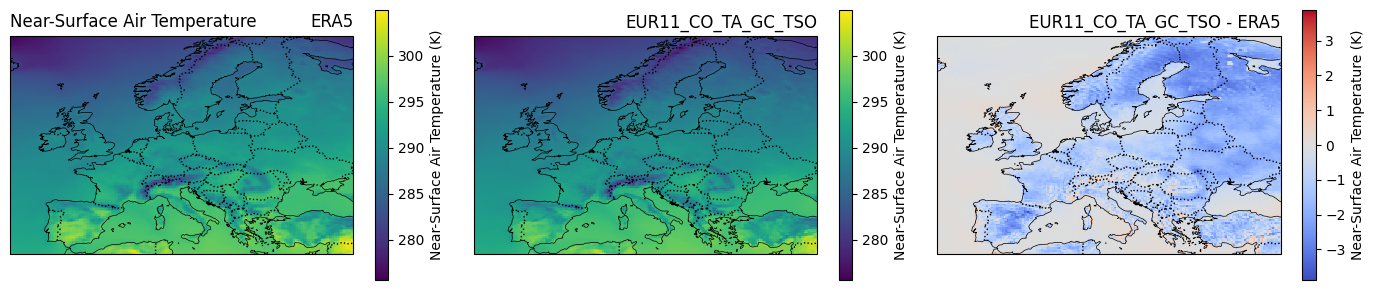

CPU times: user 17.3 s, sys: 9.15 s, total: 26.5 s
Wall time: 49.8 s


In [8]:
%%time

region = 'europe'
variable = 'tas'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)



File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/hourly/2m_temperature/era5-hourly-belgium-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
EUR11_CO_TA_GC_TSO


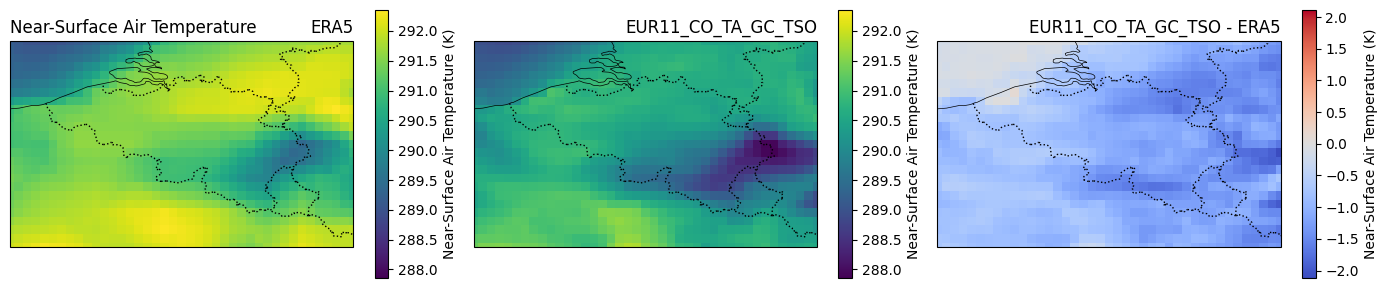

EUR11_CO_TE_GC_TSO


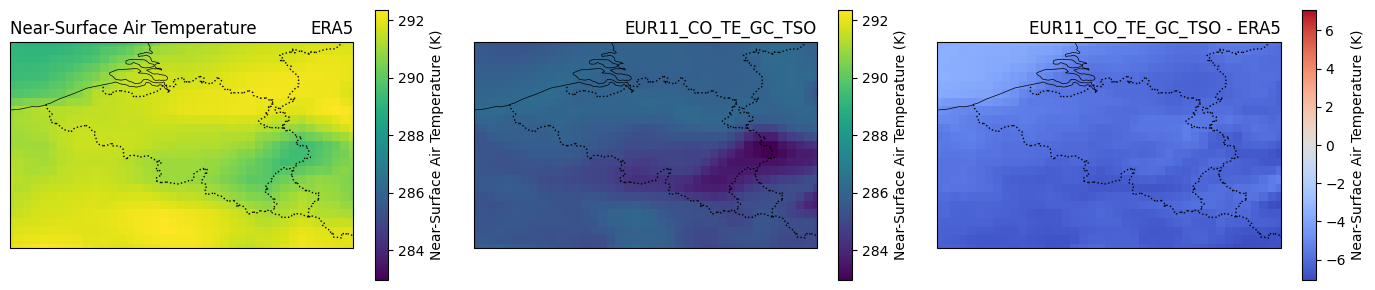

EUR11_CO_TT_GC_TSO


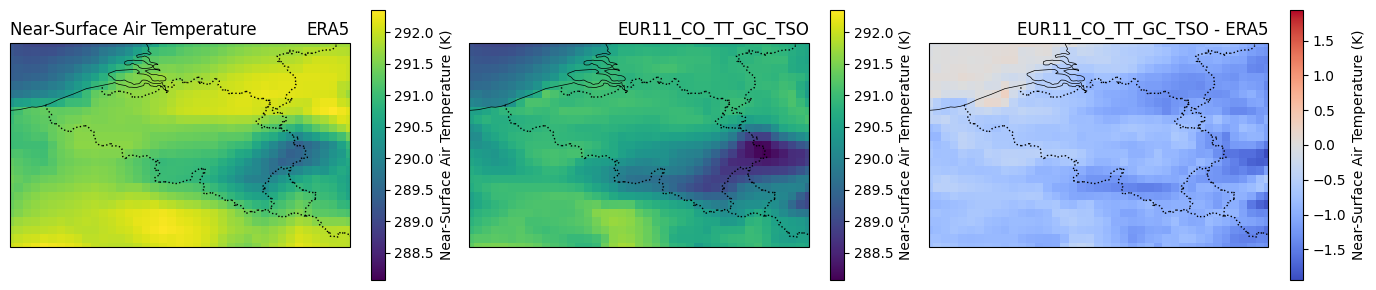

EUR11_CO_TT_EC_TSO


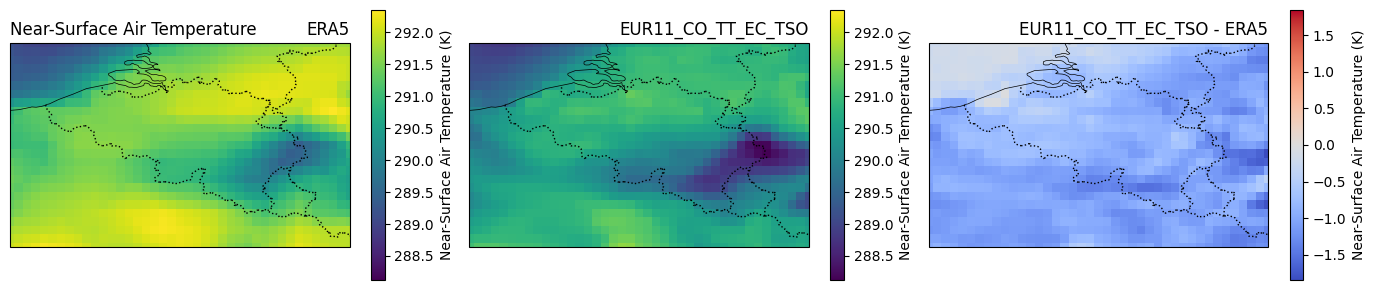

EUR11_NU_TE_GC_TSO


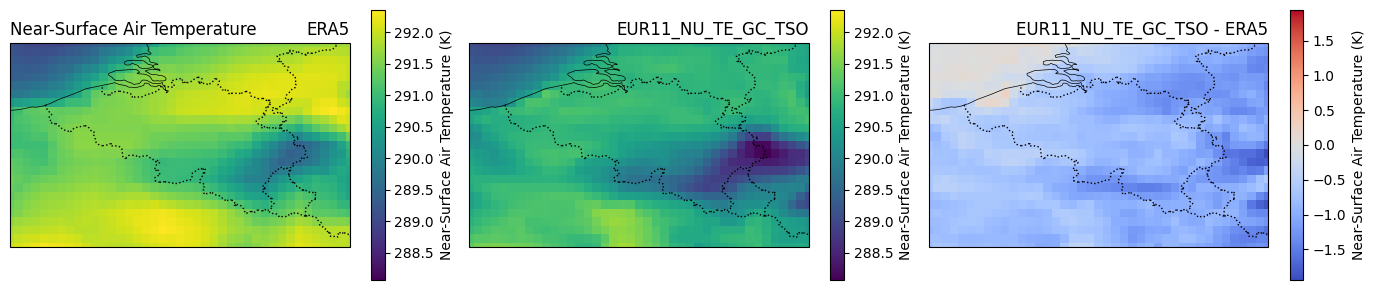

EUR11_NU_TT_GC_TSO


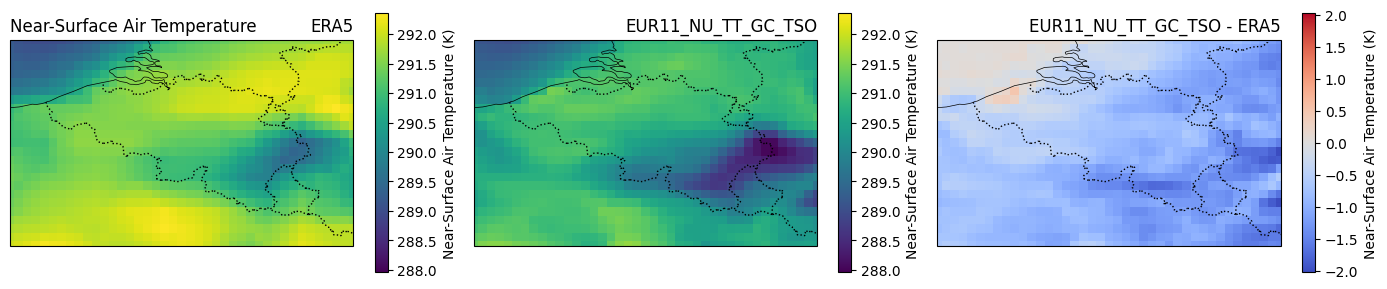

EUR11_NU_TT_EC_TSO


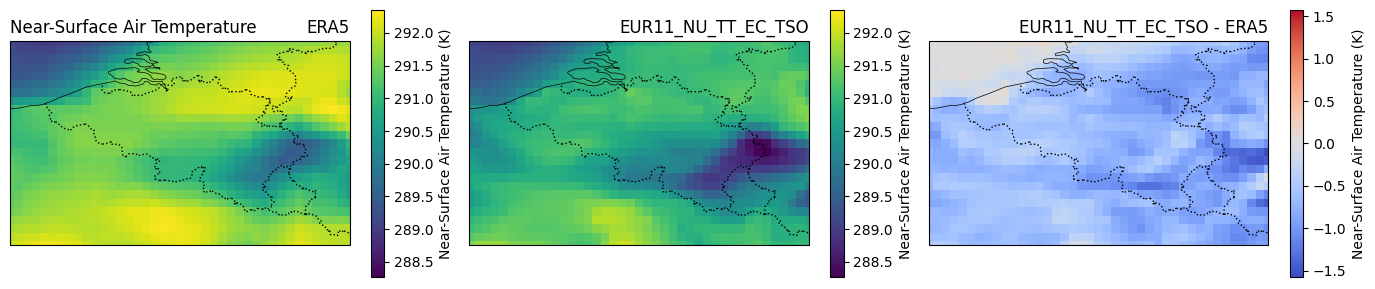

In [11]:
region = 'belgium'
variable = 'tas'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)



#### EOBS

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/EOBS/0.1deg/tg_ens_mean_0.1deg_reg_v29.0e.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
EUR11_CO_TA_GC_TSO
cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (705x465) grid


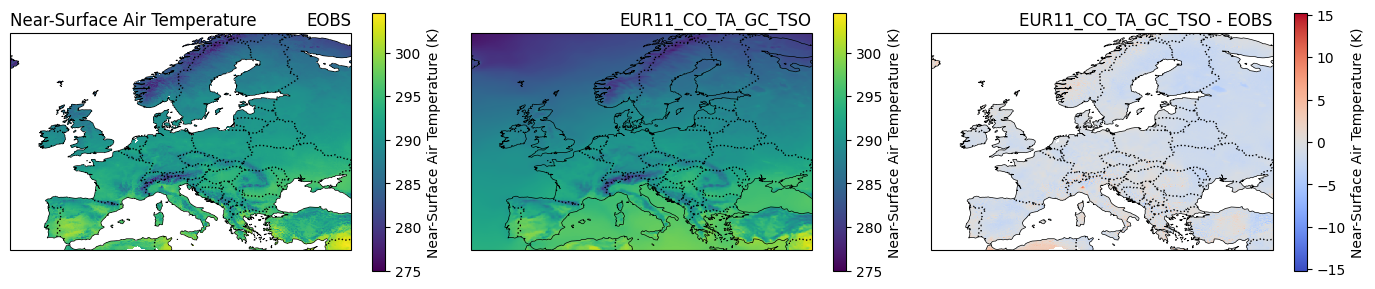

In [13]:
region = 'europe'
variable = 'tas'
ref_dataset = "EOBS"
months_to_analyse = [6,7,8]
fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)



File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/EOBS/0.1deg/tg_ens_mean_0.1deg_reg_v29.0e.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
EUR11_CO_TA_GC_TSO
cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (705x465) grid


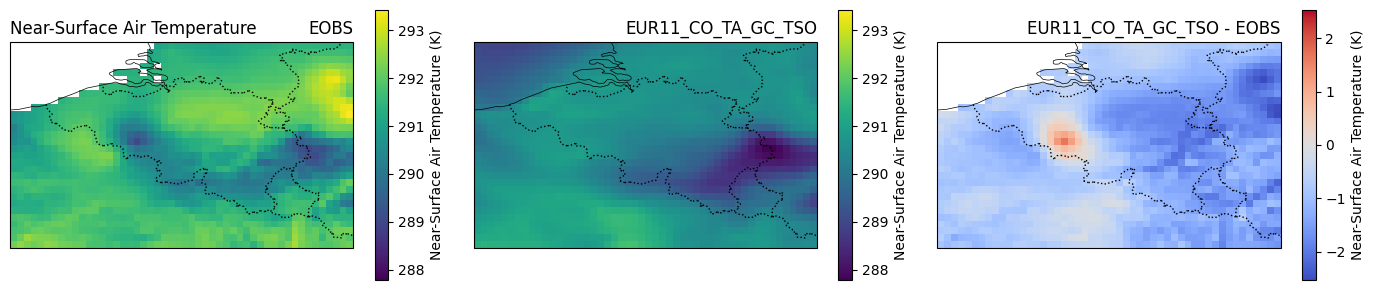

In [14]:
region = 'belgium'
variable = 'tas'
ref_dataset = "EOBS"
months_to_analyse = [6,7,8]
fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)



#### CLIMATE_GRID

File paths found:
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/CLIMATE_GRID/regridded/latlon_5km/TEMP_AVG_CLIMATE_GRID_1954_2023_daily_latlon_5km.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
EUR11_CO_TA_GC_TSO
cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (75x70) grid


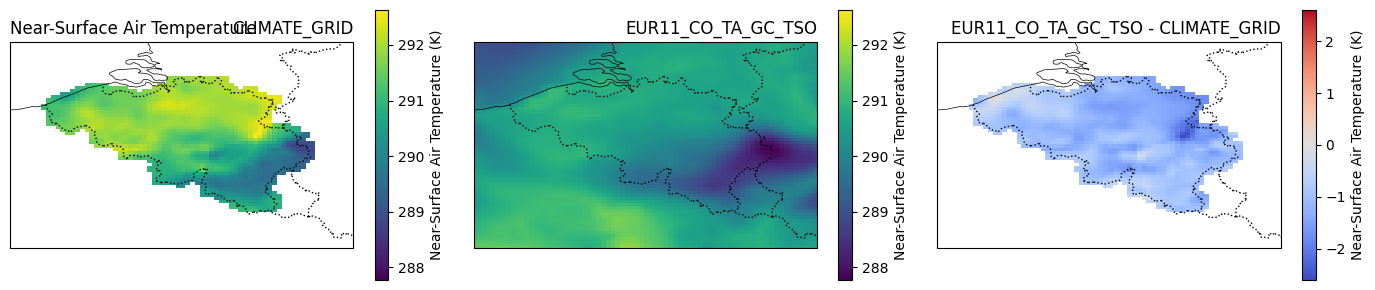

In [15]:
region = 'belgium'
variable = 'tas'
ref_dataset = "CLIMATE_GRID"
months_to_analyse = [6,7,8]
fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


#### First timestep

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/daily/2m_temperature/era5-daily-belgium-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
EUR11_CO_TA_GC_TSO
cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (41x25) grid


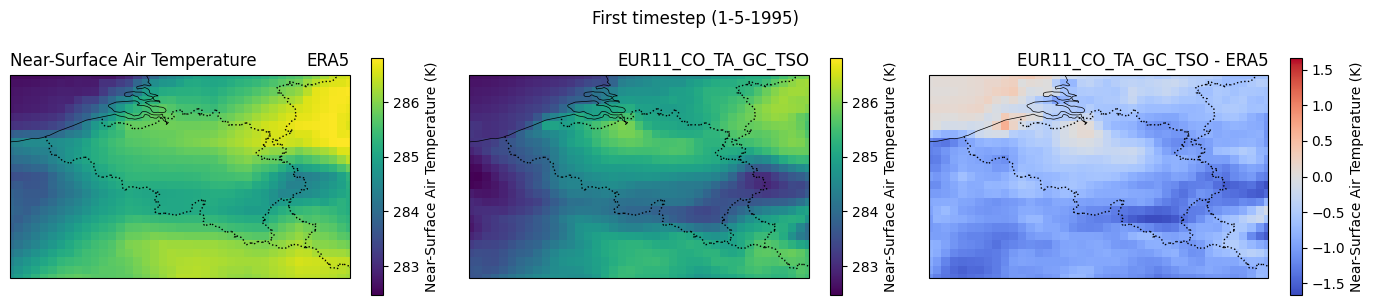

In [7]:
# first timestep plot

# ------------------------------
# 1. Load reference data

variable = 'tas'
region = 'belgium'

# start up input manager
manager = vp.InputManager(machine=machine)

# use input manager to load data, defined on settings above
ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="daily",region=region, path_identifiers = ["-daily-"])

# retrieve ERA5 gridfile - for regridding 
gridfile = manager._get_file_paths(ref_dataset, variable, period=[1995,1995], freq="daily", region=region, path_identifiers = ["-daily-"])[0]


# ------------------------------
# 2. Load and regrid model data

for experiment in experiments: 

    print(experiment)

    mod_LOOKUP = load_yml(model+"_lookup")
    # get CCLM variable corresponding to the requested variable using its look-up table
    mod_var = mod_LOOKUP[variable]['mod_name']

    # define the path
    directory = Path(postproc_base_dir + experiment +'/'+mod_var + '/')

    # define the CCLM files for the corresponding variable
    mod_files = list(directory.glob(mod_var+"_daymean.nc")) # Select all the netCDF files in the directory

    if not mod_files:  # empty list
            print(f"{variable} not available for {experiment}")
    else: 
        
        ds_mod = xr.open_mfdataset(mod_files, combine="by_coords", chunks="auto")

        # regrid
        ds_mod = remap_cdo_intermediatefiles(gridfile, ref_dataset,  mod_files, remap_method = "remapbil")
        # ds_mod = remap_cdo(gridfile, ds_mod, remap_method = "con")
        # ------------------------------
        # 3. Calculate diagnostic and do plotting
        
        # select variable and corresponding period
        da_mod = ds_mod[mod_var].sel(time='1995-05-01')
        da_obs = ds_obs[variable].sel(time='1995-05-01').mean('time')

        lat_bounds = bounds[region]['lat_bounds']
        lon_bounds = bounds[region]['lon_bounds']

        da_mod = da_mod.sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0], lat_bounds[1]))
        da_obs = da_obs.sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0], lat_bounds[1]))
        bias = da_mod - da_obs


        fig, axes = plt.subplots(1, 3, figsize=(14, 3), subplot_kw={'projection': ccrs.PlateCarree()})
        axes = axes.flatten()

        # find plotting min and max
        vmin = float(min(da_mod.min().values, da_obs.min().values))
        vmax = float(max(da_mod.max().values, da_obs.max().values))

        bias_bound = float(max(abs(bias.min().values), abs(bias.max().values)))


        cbar_label = f"{da_obs.attrs['long_name']} ({da_obs.attrs['units']})"
        cbar_kwargs = {'label': cbar_label}


        # Define a function to add borders, coastlines to the axes
        def add_features(ax):
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            ax.add_feature(cfeature.COASTLINE, linewidth = 0.5, color = 'k')
            ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())

        # obs
        ax = axes[0]
        da_obs.plot(ax=ax, vmin=vmin, vmax=vmax, cbar_kwargs=cbar_kwargs)
        ax.set_title(da_obs.attrs['long_name'], loc='left')
        ax.set_title('')
        ax.set_title(ref_dataset, loc='right')
        add_features(ax)

        # mod
        ax = axes[1]
        da_mod.plot(ax=ax, vmin=vmin, vmax=vmax, cbar_kwargs=cbar_kwargs)
        ax.set_title('')
        ax.set_title(experiment, loc='right')
        add_features(ax)

        # bias
        ax = axes[2]
        bias.plot(ax=ax, cmap = 'coolwarm', vmax = bias_bound, vmin = - bias_bound, cbar_kwargs=cbar_kwargs)
        ax.set_title('')
        ax.set_title(f"{experiment} - {ref_dataset}", loc='right')
        add_features(ax)
        fig.suptitle(f"First timestep (1-5-1995)", y=1);
        fig.tight_layout()
        plt.show()



## surface temperature

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/daily/skin_temperature/era5-land-daily-belgium-skin_temperature-1995.nc
The file is ValEnsPy CF compliant.
50.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['ts']
Unknown to ValEnsPy: ['time_bnds']
EUR11_CO_TA_GC_TSO
cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (41x25) grid


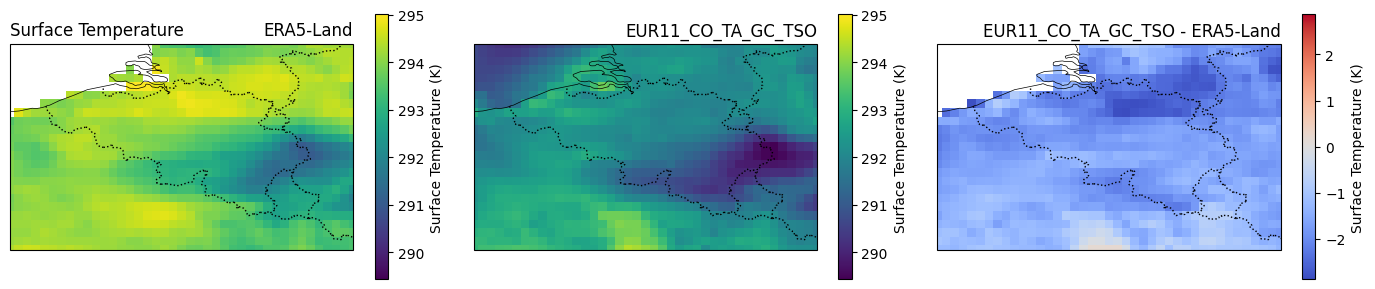

In [6]:
region = 'belgium'
variable = 'ts'
ref_dataset = "ERA5-Land"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/2m_temperature/era5-land-hourly-belgium-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
EUR11_CO_TA_GC_TSO
cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (41x25) grid


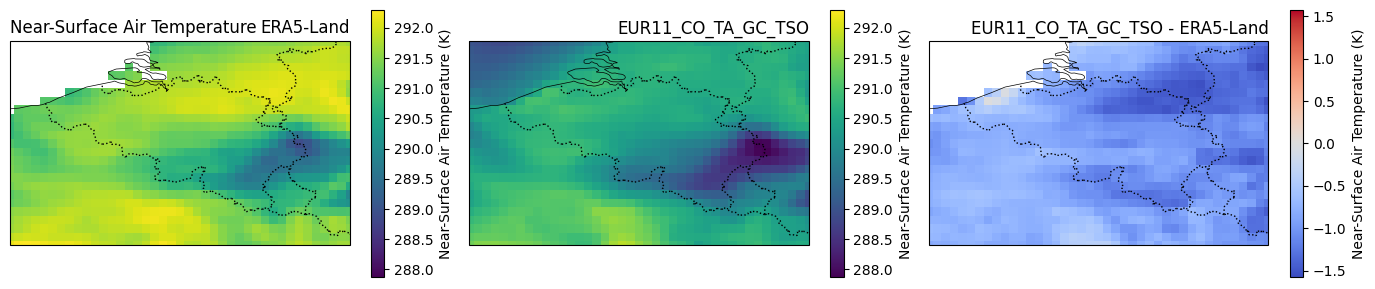

In [18]:
region = 'belgium'
variable = 'tas'
ref_dataset = "ERA5-Land"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


## Precipitation

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/total_precipitation/era5-hourly-europe-total_precipitation-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['pr']
The following attributes are missing or incorrect for the variable pr:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           m                         kg m-2 s-1               
did pr unit conversion
EUR11_CO_TA_GC_TSO
cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (289x163) grid


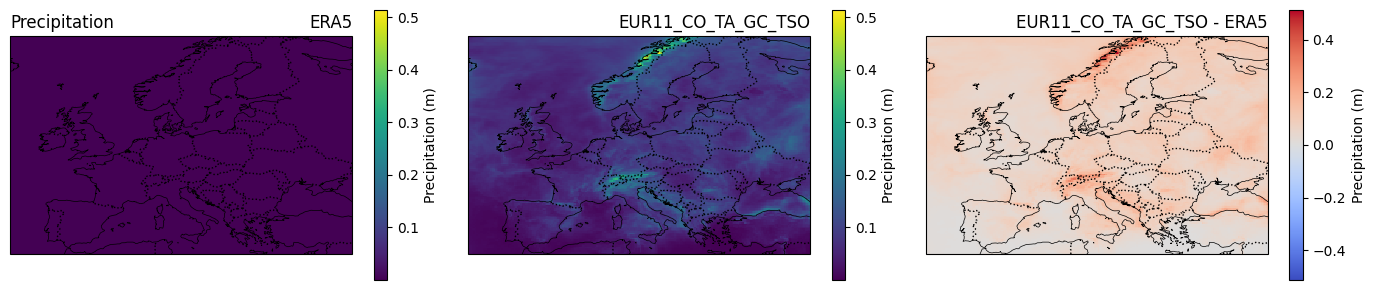

In [5]:
region = 'europe'
variable = 'pr'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

unit_conversion='pr' # hack for quick fix of ERA5 unit conversion -- does not work!!!

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region, unit_conversion)

## Cloudiness

### total cloud percentage

In [19]:
region = 'belgium'
variable = 'clt'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments, months_to_analyse, region)


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/daily/total_cloud_cover/era5-daily-belgium-total_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['clt']
Unknown to ValEnsPy: ['time_bnds']
The following attributes are missing or incorrect for the variable clt:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           (0 - 1)                   %                        
EUR11_CO_TA_GC_TSO


### low  cloud percentage

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/low_cloud_cover/era5-hourly-europe-low_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['cll']
The following attributes are missing or incorrect for the variable cll:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           (0 - 1)                   %                        
EUR11_CO_TA_GC_TSO
cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (289x163) grid


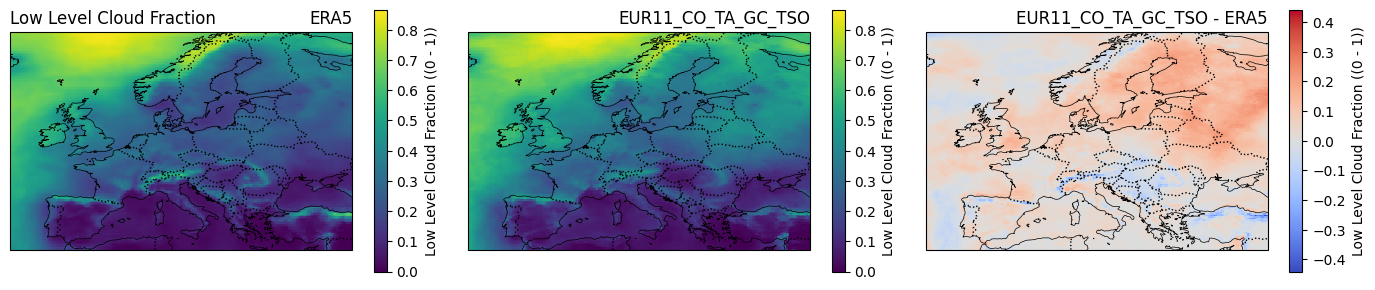

In [6]:
mod_variable = "CLCL"

region = 'europe'
variable = 'cll'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/hourly/low_cloud_cover/era5-hourly-belgium-low_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['cll']
The following attributes are missing or incorrect for the variable cll:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           (0 - 1)                   %                        
EUR11_CO_TA_GC_TSO


cdi  warning (cdfInqContents): Coordinates variable number can't be assigned!


cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (41x25) grid


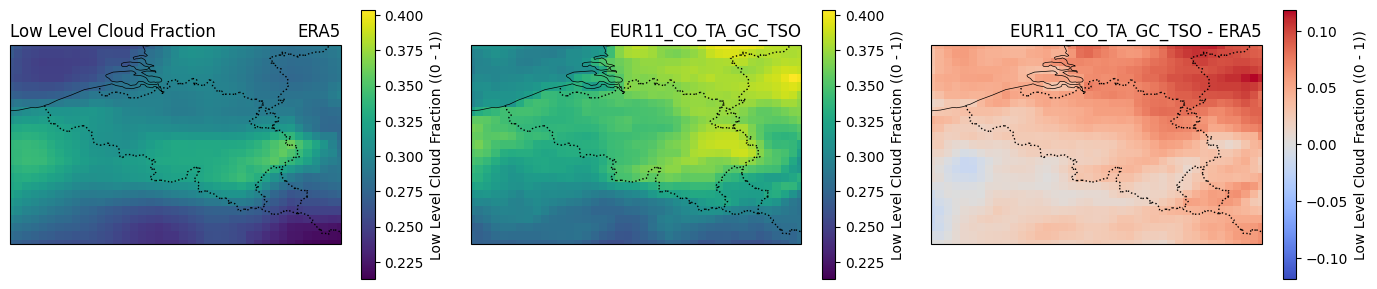

In [7]:
mod_variable = "CLCL"

region = 'belgium'
variable = 'cll'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


### medium  cloud percentage

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/medium_cloud_cover/era5-hourly-europe-medium_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['clm']
The following attributes are missing or incorrect for the variable clm:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           (0 - 1)                   %                        


EUR11_CO_TA_GC_TSO
cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (289x163) grid


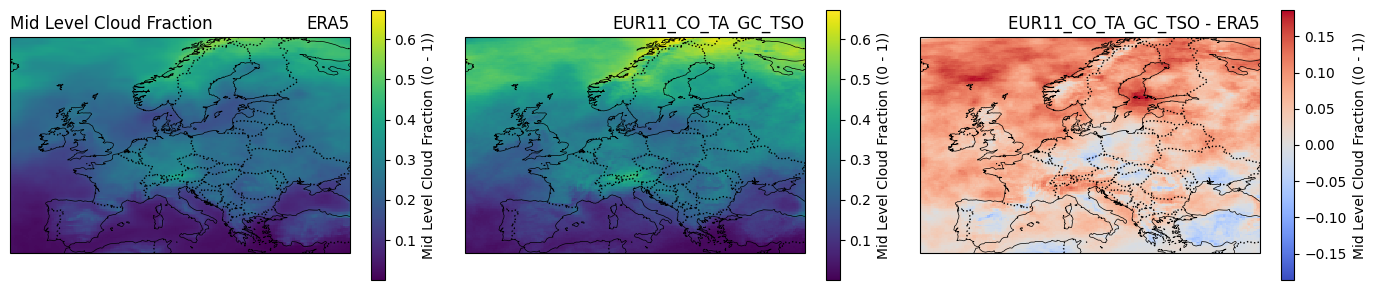

In [6]:
mod_variable = "CLCM"

region = 'europe'
variable = 'clm'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/hourly/medium_cloud_cover/era5-hourly-belgium-medium_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['clm']
The following attributes are missing or incorrect for the variable clm:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           (0 - 1)                   %                        
EUR11_CO_TA_GC_TSO


cdi  warning (cdfInqContents): Coordinates variable number can't be assigned!


cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (41x25) grid


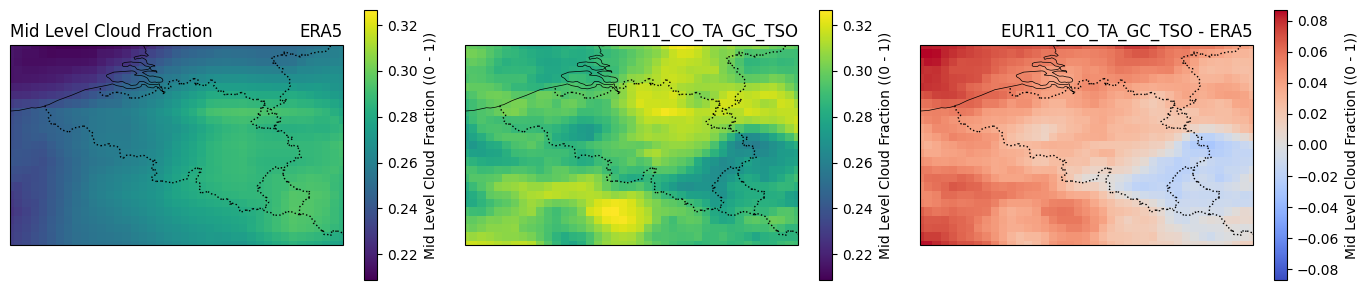

In [8]:
mod_variable = "CLCM"

region = 'belgium'
variable = 'clm'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


### High  cloud percentage

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/high_cloud_cover/era5-hourly-europe-high_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['clh']
The following attributes are missing or incorrect for the variable clh:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           (0 - 1)                   %                        
EUR11_CO_TA_GC_TSO


cdi  warning (cdfInqContents): Coordinates variable number can't be assigned!
cdi  warning (cdfInqContents): Coordinates variable surface can't be assigned!


cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (289x163) grid


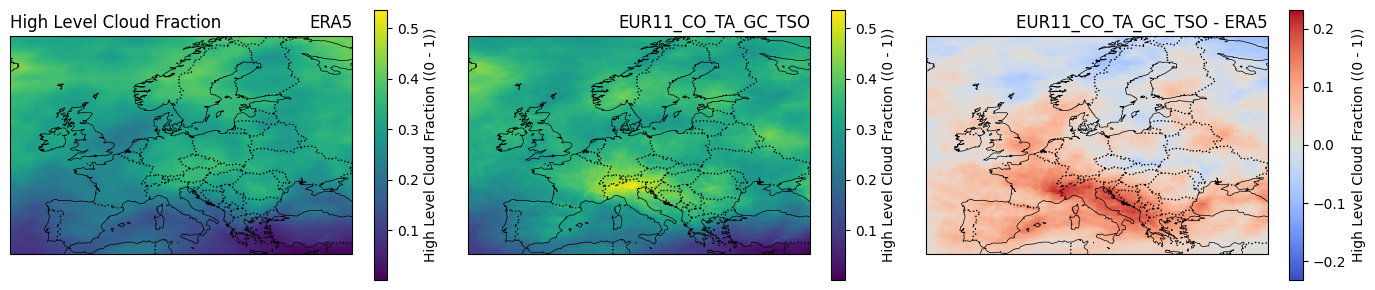

In [42]:
mod_variable = "CLCH"

region = 'europe'
variable = 'clh'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/hourly/high_cloud_cover/era5-hourly-belgium-high_cloud_cover-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['clh']
The following attributes are missing or incorrect for the variable clh:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           (0 - 1)                   %                        
EUR11_CO_TA_GC_TSO


cdi  warning (cdfInqContents): Coordinates variable number can't be assigned!


cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (41x25) grid


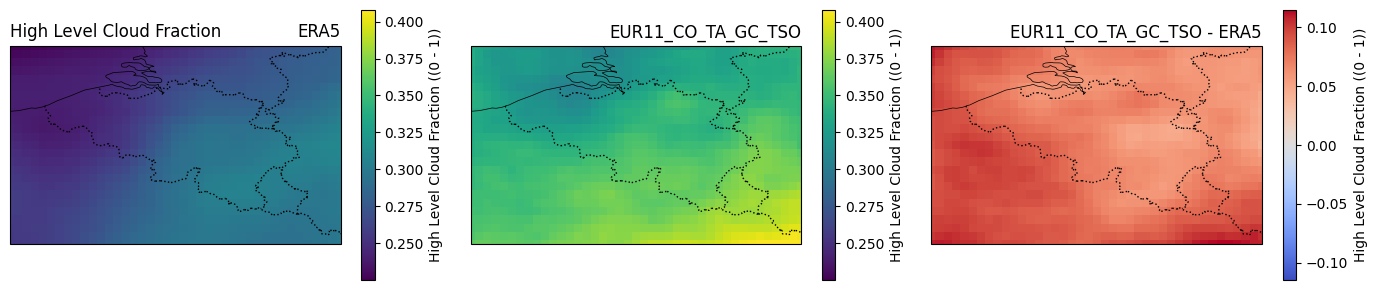

In [9]:
mod_variable = "CLCH"

region = 'belgium'
variable = 'clh'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


## Mean sea level pressure

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/daily/mean_sea_level_pressure/era5-daily-europe-mean_sea_level_pressure-1995.nc


The file is ValEnsPy CF compliant.
50.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['psl']
Unknown to ValEnsPy: ['time_bnds']
EUR11_CO_TA_GC_TSO
cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (289x163) grid


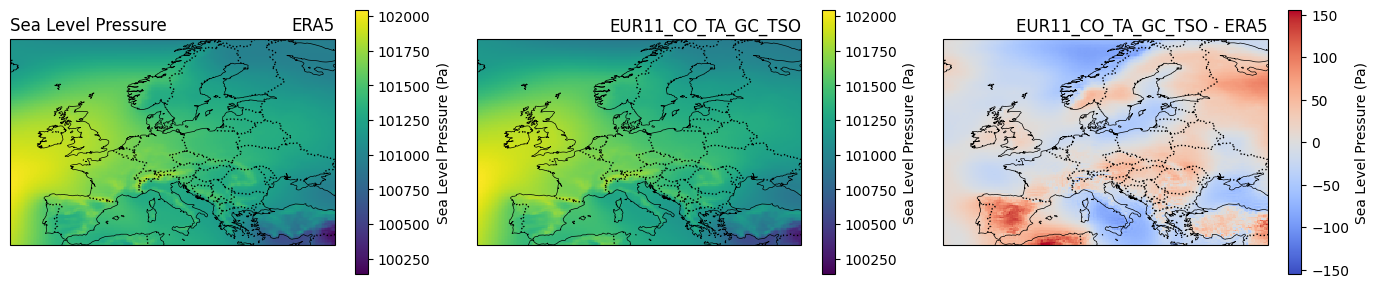

In [7]:
region = 'europe'
variable = 'psl'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/belgium/daily/mean_sea_level_pressure/era5-daily-belgium-mean_sea_level_pressure-1995.nc
The file is ValEnsPy CF compliant.
50.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['psl']
Unknown to ValEnsPy: ['time_bnds']
EUR11_CO_TA_GC_TSO


cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (41x25) grid


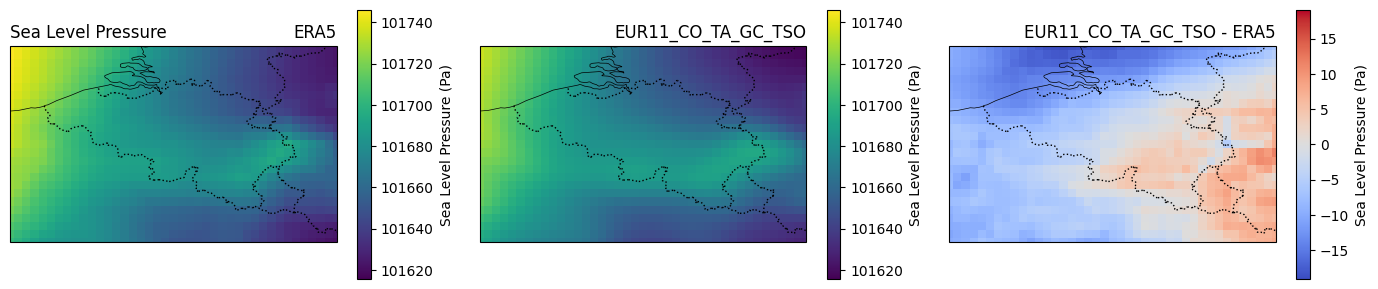

In [8]:
region = 'belgium'
variable = 'psl'
ref_dataset = "ERA5"
months_to_analyse = [6,7,8]

load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region)

## Radiation and turbulent fluxes

#### latent heat flux

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/surface_latent_heat_flux/era5-land-hourly-belgium-surface_latent_heat_flux-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['hfls']
The following attributes are missing or incorrect for the variable hfls:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           J m**-2                   W m-2                    
did unit conversion
EUR11_CO_TA_GC_TSO


cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (41x25) grid


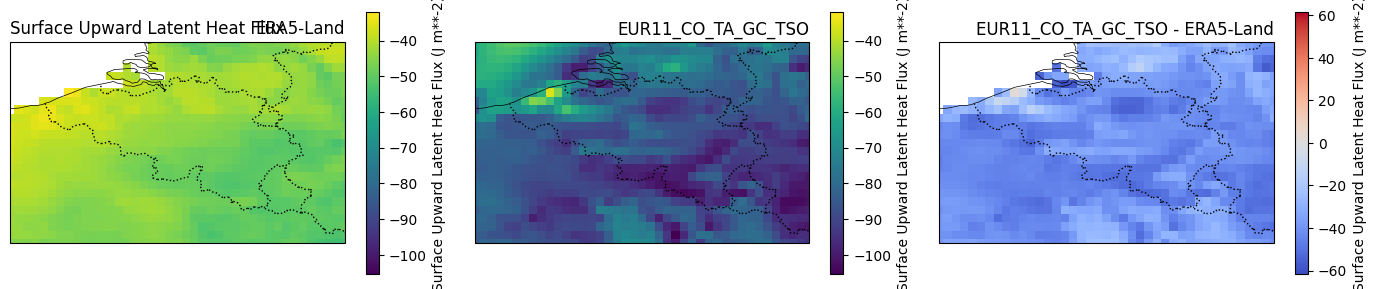

In [10]:
region = 'belgium'
variable = 'hfls'
ref_dataset = "ERA5-Land"
months_to_analyse = [6,7,8]

unit_conversion=True # hack for quick fix of ERA5 unit conversion

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region, unit_conversion)


#### sensible heat flux

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/surface_sensible_heat_flux/era5-land-hourly-belgium-surface_sensible_heat_flux-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['hfss']
The following attributes are missing or incorrect for the variable hfss:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           J m**-2                   W m-2                    
did unit conversion
EUR11_CO_TA_GC_TSO
cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (41x25) grid


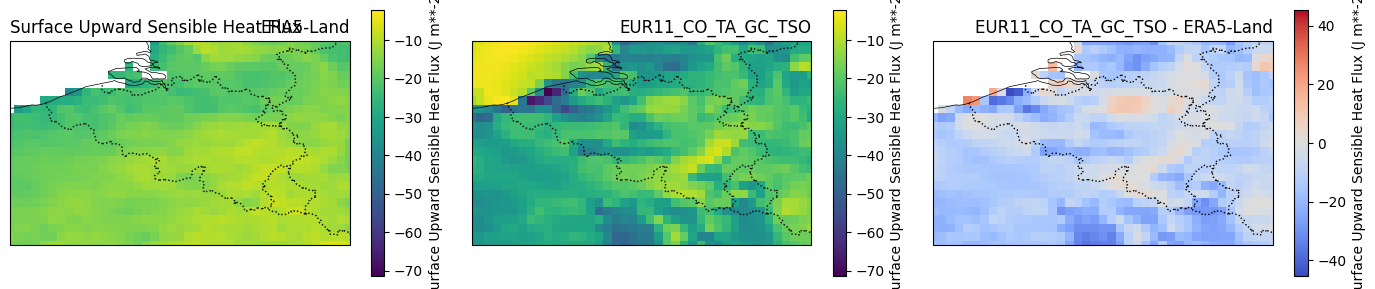

In [11]:
region = 'belgium'
variable = 'hfss'
ref_dataset = "ERA5-Land"
months_to_analyse = [7,8]

unit_conversion=True # hack for quick fix of ERA5 unit conversion

fig = load_calc_plot_bias_map(variable, ref_dataset, experiments , months_to_analyse, region, unit_conversion)


#### SW down surface

In [2]:
# surface solar radation downwards
variable = 'rsds'

#### LW down surface

In [ ]:
# surface_thermal_radiation_downwards
variable = 'rlds'


#### Incident SW TOA

In [ ]:
variable = 'rsdt'

#### Incident LW TOA

## Hydrometeors
Until conversion from ERA5, only CCLM maps

In [12]:
variables =  [ 'TQR', 'TQV', 'TQC', 'TQI', 'TQG', 'TQS', 'CLCH']

CLCH not available for EUR11_CO_TA_GC_TSO


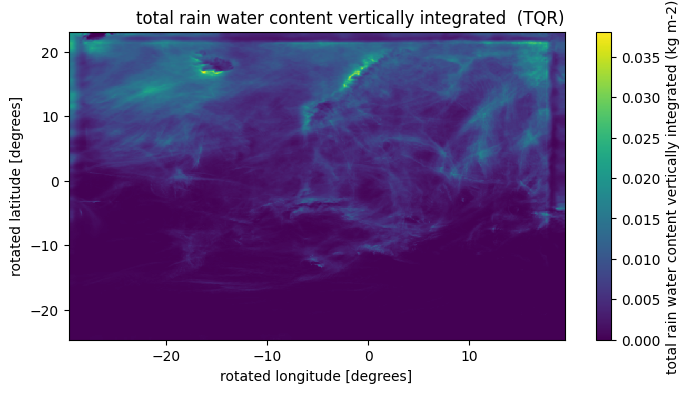

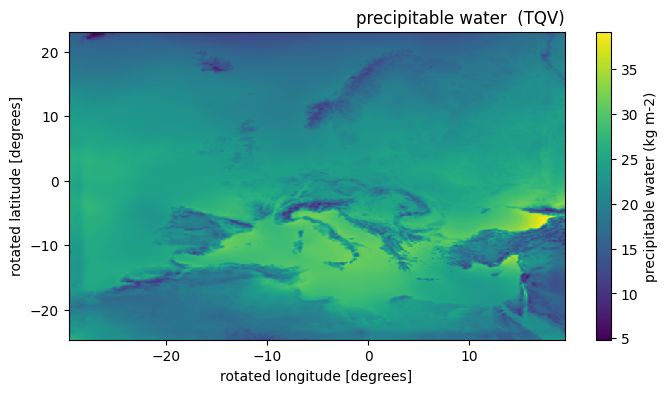

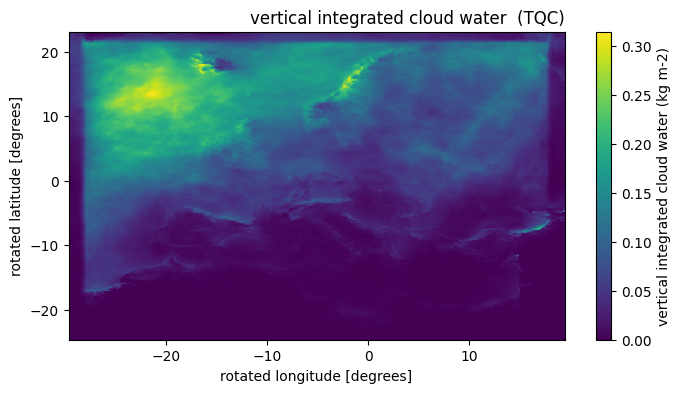

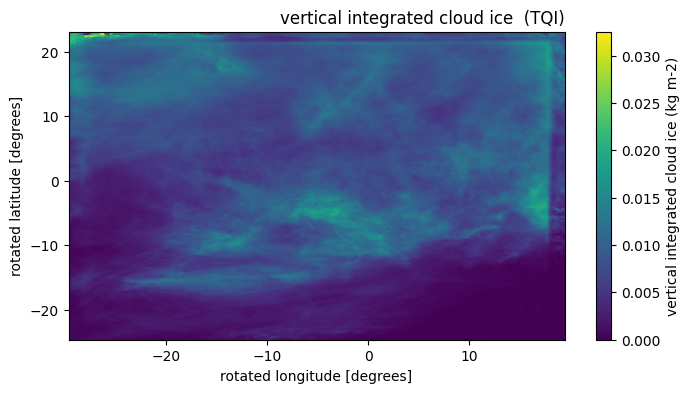

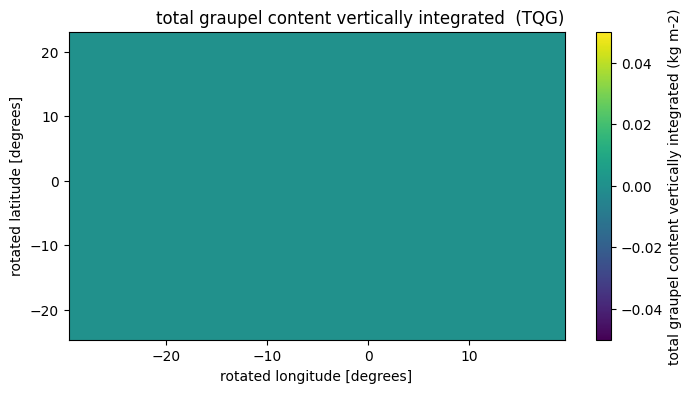

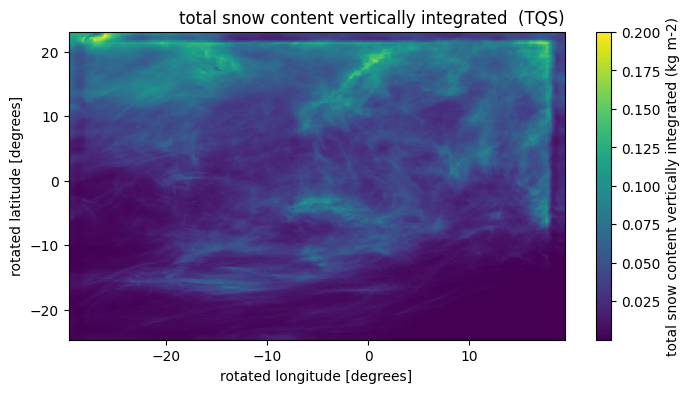

In [15]:
# ------------------------------
# 2. Load and regrid model data

for mod_var in variables: 

    # define the path
    directory = Path(postproc_base_dir + experiment +'/'+mod_var + '/')

    # define the CCLM files for the corresponding variable
    mod_files = list(directory.glob(mod_var+"_daymean.nc")) # Select all the netCDF files in the directory

    if not mod_files:  # empty list
            print(f"{mod_var} not available for {experiment}")
    else: 
        
        ds_mod = xr.open_mfdataset(mod_files, combine="by_coords", chunks="auto")
        
        # select variable and corresponding period
        da_mod = ds_mod[mod_var].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse)).mean('time')

        lat_bounds = bounds[region]['lat_bounds']
        lon_bounds = bounds[region]['lon_bounds']

        #da_mod = da_mod.sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0], lat_bounds[1]))


        fig, ax = plt.subplots(1, 1, figsize=(8, 4))

        cbar_label = f"{da_mod.attrs['long_name']} ({da_mod.attrs['units']})"
        cbar_kwargs = {'label': cbar_label}

        # Define a function to add borders, coastlines to the axes
        def add_features(ax):
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            ax.add_feature(cfeature.COASTLINE, linewidth = 0.5, color = 'k')
            ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())
        # mod
        da_mod.plot(ax=ax, cbar_kwargs=cbar_kwargs)
        ax.set_title('')
        ax.set_title(f"{da_mod.attrs['long_name']}  ({mod_var})", loc='right')
        #add_features(ax)

 
